# Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles 
This is the code for the paper entitled "[**Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles**](https://arxiv.org/pdf/1910.08635.pdf)" published in IEEE GlobeCom 2019.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, Ismail Hamieh, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, I. Hamieh and A. Shami, "Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles," 2019 IEEE Global Communications Conference (GLOBECOM), 2019, pp. 1-6, doi: 10.1109/GLOBECOM38437.2019.9013892.  

## Import libraries

In [66]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [68]:
#Read dataset
df = pd.read_csv('./KDDdataset.csv')
# The results in this code is based on the original CICIDS2017 dataset. Please go to cell [10] if you work on the sampled dataset. 

In [69]:
df

,0,tcp,http,SF,215,45076,0.1,0.2,0.3,0.4,...,0.17,0.00.6,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,0.00.12,0.00.13,normal.
0,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,238,1282,0,0,0,0,...,5,1.0,0.0,0.20,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898425,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898426,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


In [70]:
df.Label.value_counts()

AttributeError: 'DataFrame' object has no attribute 'Label'

### Data sampling
Due to the space limit of GitHub files, we sample a small-sized subset for model learning using random sampling

In [ ]:
# Randomly sample instances from majority classes
df_minor = df[(df['Label']=='WebAttack')|(df['Label']=='Bot')|(df['Label']=='Infiltration')]
df_BENIGN = df[(df['Label']=='BENIGN')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.01, replace=False, weights=None, random_state=None, axis=0)
df_DoS = df[(df['Label']=='DoS')]
df_DoS = df_DoS.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_PortScan = df[(df['Label']=='PortScan')]
df_PortScan = df_PortScan.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_BruteForce = df[(df['Label']=='BruteForce')]
df_BruteForce = df_BruteForce.sample(n=None, frac=0.2, replace=False, weights=None, random_state=None, axis=0)

In [ ]:
df_s = df_BENIGN.append(df_DoS).append(df_PortScan).append(df_BruteForce).append(df_minor)

In [ ]:
df_s = df_s.sort_index()

In [ ]:
# Save the sampled dataset
df_s.to_csv('./data/CICIDS2017_sample.csv',index=0)

### Preprocessing (normalization and padding values)

In [ ]:
df = pd.read_csv('./KDDdataset.csv')

In [ ]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(5048, 77)

In [ ]:
pd.Series(y_train).value_counts()

6    1744
1    1573
3     761
2     442
5     317
0     182
4      29
dtype: int64

### Oversampling by SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"

In [ ]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

1    1744
6    1744
3    1744
2    1744
5    1744
0    1744
4    1744
dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.9873317498020586
Precision of DT: 0.9874810361590656
Recall of DT: 0.9873317498020586
F1-score of DT: 0.9873567512110695
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        45
           1       0.99      0.99      0.99       393
           2       0.98      1.00      0.99       111
           3       0.99      0.99      0.99       191
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00        80
           6       1.00      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.95      0.94      0.94      1263
weighted avg       0.99      0.99      0.99      1263



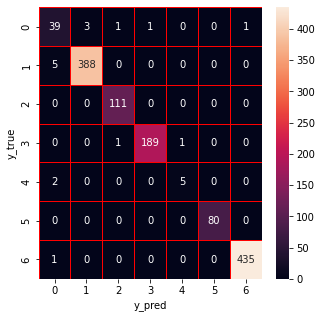

In [ ]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9865399841646872
Precision of RF: 0.9864599086765268
Recall of RF: 0.9865399841646872
F1-score of RF: 0.9864521466642351
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        45
           1       0.99      0.99      0.99       393
           2       0.97      1.00      0.99       111
           3       0.99      0.98      0.98       191
           4       0.83      0.71      0.77         7
           5       0.99      1.00      0.99        80
           6       1.00      0.99      0.99       436

    accuracy                           0.99      1263
   macro avg       0.95      0.94      0.94      1263
weighted avg       0.99      0.99      0.99      1263



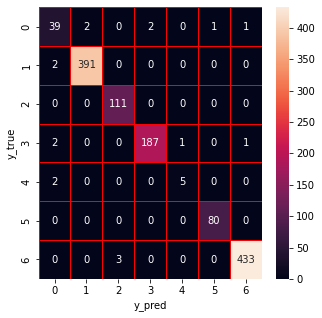

In [ ]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9881235154394299
Precision of ET: 0.9882833069299258
Recall of ET: 0.9881235154394299
F1-score of ET: 0.9880471519667423
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        45
           1       0.99      0.99      0.99       393
           2       0.97      1.00      0.99       111
           3       0.99      0.98      0.99       191
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00        80
           6       1.00      0.99      0.99       436

    accuracy                           0.99      1263
   macro avg       0.98      0.94      0.95      1263
weighted avg       0.99      0.99      0.99      1263



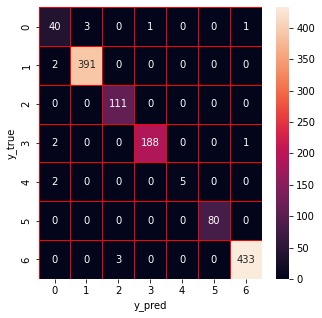

In [ ]:
# Extra trees training and prediction
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9865399841646872
Precision of XGBoost: 0.986554061712048
Recall of XGBoost: 0.9865399841646872
F1-score of XGBoost: 0.986492550660558
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        45
           1       0.99      0.99      0.99       393
           2       0.98      1.00      0.99       111
           3       0.99      0.97      0.98       191
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00        80
           6       0.99      1.00      0.99       436

    accuracy                           0.99      1263
   macro avg       0.95      0.94      0.94      1263
weighted avg       0.99      0.99      0.99      1263



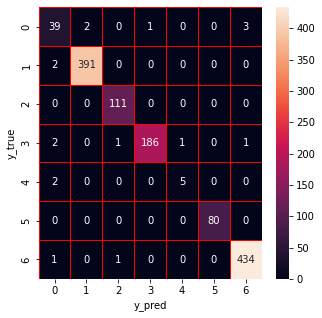

In [ ]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)

In [ ]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,1,1,1,1
1,6,6,6,6
2,3,3,3,3
3,6,6,6,6
4,2,2,2,2


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Accuracy of Stacking: 0.9857482185273159
Precision of Stacking: 0.985911782981983
Recall of Stacking: 0.9857482185273159
F1-score of Stacking: 0.985771453728001
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        45
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00       111
           3       0.99      0.98      0.99       191
           4       0.83      0.71      0.77         7
           5       0.98      1.00      0.99        80
           6       1.00      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.95      0.93      0.94      1263
weighted avg       0.99      0.99      0.99      1263



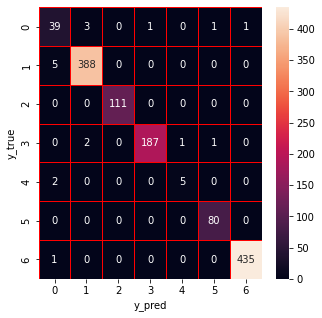

In [ ]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Feature Selection

### Feature importance

In [ ]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [ ]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [ ]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.0837, 'Init_Win_bytes_backward'), (0.0786, 'Total Length of Fwd Packets'), (0.0531, 'Bwd Packet Length Min'), (0.0442, 'min_seg_size_forward'), (0.0378, 'PSH Flag Count'), (0.0351, 'Bwd Packets/s'), (0.0337, 'Subflow Fwd Bytes'), (0.0304, 'Packet Length Variance'), (0.0288, 'Average Packet Size'), (0.0271, 'Fwd Packet Length Std'), (0.026, 'Bwd Header Length'), (0.0255, 'Total Fwd Packets'), (0.0255, 'Bwd Packet Length Std'), (0.0242, 'Init_Win_bytes_forward'), (0.0217, 'act_data_pkt_fwd'), (0.0199, 'Bwd Packet Length Mean'), (0.019, 'Max Packet Length'), (0.0185, 'Avg Bwd Segment Size'), (0.0179, 'Packet Length Mean'), (0.0159, 'Bwd IAT Min'), (0.0143, 'Fwd PSH Flags'), (0.0141, 'Flow IAT Max'), (0.014, 'URG Flag Count'), (0.0138, 'Fwd Header Length'), (0.0134, 'Flow Duration'), (0.0126, 'Bwd Packet Length Max'), (0.0123, 'Fwd Packet Length Mean'), (0.012, 'Total Backward Packets'), (0.0117, 'Min Packet Length'), (0.0116, 'Flow IAT Std'), (0.0115, '

In [ ]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [ ]:
len(f_list)

77

In [ ]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [ ]:
X_fs = df[fs].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(5048, 41)

In [ ]:
pd.Series(y_train).value_counts()

6    1744
1    1573
3     761
2     442
5     317
0     182
4      29
dtype: int64

### Oversampling by SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500})

In [ ]:
oversample = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

6    1744
1    1573
4    1500
3     761
2     442
5     317
0     182
dtype: int64

## Machine learning model training after feature selection

Accuracy of DT: 0.9841646872525732
Precision of DT: 0.9843152100251882
Recall of DT: 0.9841646872525732
F1-score of DT: 0.9842059662098318
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        45
           1       1.00      0.99      0.99       393
           2       0.98      1.00      0.99       111
           3       0.98      0.97      0.98       191
           4       0.71      0.71      0.71         7
           5       1.00      0.99      0.99        80
           6       0.99      1.00      1.00       436

    accuracy                           0.98      1263
   macro avg       0.93      0.93      0.93      1263
weighted avg       0.98      0.98      0.98      1263



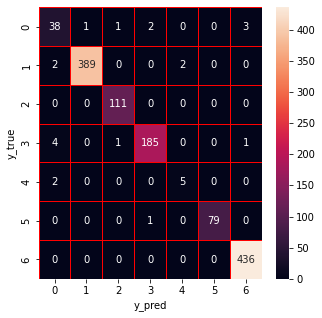

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9865399841646872
Precision of RF: 0.9862087954450552
Recall of RF: 0.9865399841646872
F1-score of RF: 0.9863211830347902
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        45
           1       0.99      0.99      0.99       393
           2       0.99      1.00      1.00       111
           3       0.99      0.98      0.98       191
           4       0.83      0.71      0.77         7
           5       0.99      1.00      0.99        80
           6       0.99      1.00      0.99       436

    accuracy                           0.99      1263
   macro avg       0.95      0.93      0.94      1263
weighted avg       0.99      0.99      0.99      1263



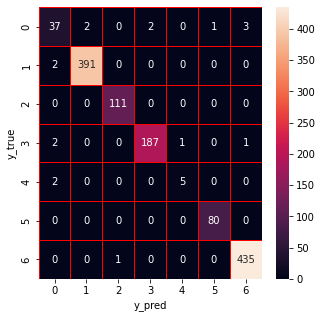

In [ ]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9881235154394299
Precision of ET: 0.9880436158340881
Recall of ET: 0.9881235154394299
F1-score of ET: 0.9880707936004174
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        45
           1       0.99      0.99      0.99       393
           2       0.98      1.00      0.99       111
           3       0.99      0.99      0.99       191
           4       0.71      0.71      0.71         7
           5       1.00      1.00      1.00        80
           6       1.00      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.94      0.93      0.93      1263
weighted avg       0.99      0.99      0.99      1263



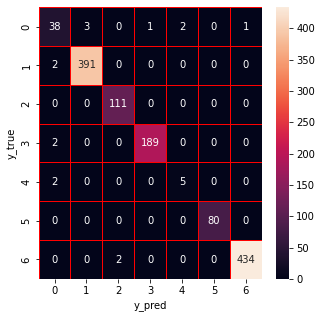

In [ ]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9881235154394299
Precision of XGBoost: 0.9880874746032388
Recall of XGBoost: 0.9881235154394299
F1-score of XGBoost: 0.988063475274008
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        45
           1       0.99      0.99      0.99       393
           2       0.99      1.00      1.00       111
           3       0.99      0.97      0.98       191
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00        80
           6       0.99      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.95      0.94      0.95      1263
weighted avg       0.99      0.99      0.99      1263



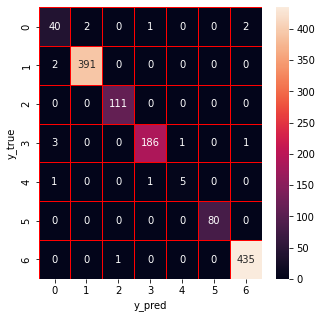

In [ ]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [ ]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,1,1,1,1
1,6,6,6,6
2,3,3,3,3
3,6,6,6,6
4,2,2,2,2


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9857482185273159
Precision of Stacking: 0.9859307441364995
Recall of Stacking: 0.9857482185273159
F1-score of Stacking: 0.9857863398425916
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        45
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00       111
           3       1.00      0.97      0.98       191
           4       0.71      0.71      0.71         7
           5       1.00      0.99      0.99        80
           6       0.99      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.93      0.93      0.93      1263
weighted avg       0.99      0.99      0.99      1263



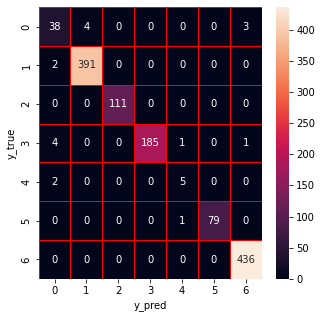

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()